In [1]:
import tensorflow as tf
import cv2
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K
import math
from matplotlib import pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, batch_size, input_shape, data, labels,
                 shuffle=True):
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.data = data
        self.labels = labels
        self.indices = np.arange(len(self.data))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))
       
    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size : (index+1)*self.batch_size]
        batch_x = [cv2.cvtColor(cv2.imread(self.data[index]), cv2.COLOR_BGR2RGB) / 255.0 for index in batch_indices]
        batch_y = [cv2.cvtColor(cv2.imread(self.labels[index]), cv2.COLOR_BGR2RGB) / 255.0 for index in batch_indices]
        return np.array(batch_x), np.array(batch_y)

    def on_epoch_end(self):
        self.indices = np.arange(len(self.data))
        if self.shuffle:
            np.random.shuffle(self.indices)

In [4]:
data = []
labels = []
with open('./dataset_cubic.txt', 'r') as f:
    for line in f:
        line = line.strip()
        entry = './DIV2K_processed_cubic/' + line
        data.append(entry + '_X_.png')
        labels.append(entry + '_y_.png')

In [5]:
print(data[0], labels[0])

./DIV2K_processed_cubic/0001-0-0_X_.png ./DIV2K_processed_cubic/0001-0-0_y_.png


In [6]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.05, random_state=42)

In [8]:
print(len(X_test))

242


In [9]:
train_generator = DataGenerator(128, (64, 64, 3), X_train, y_train, shuffle=True)
test_generator = DataGenerator(128, (64, 64, 3), X_test, y_test, shuffle=True)

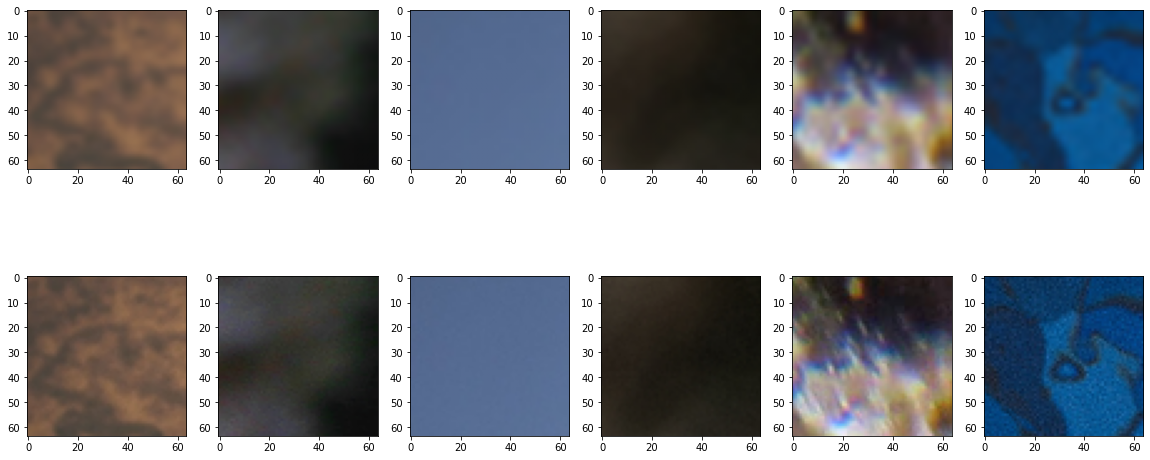

In [10]:
batch_x, batch_y = train_generator[0]

fig, axes = plt.subplots(nrows=2, ncols=6, figsize=[20, 9])
for i in range(len(axes[0])):
    axes[0, i].imshow(batch_x[i])
    axes[1, i].imshow(batch_y[i])
plt.show()

In [11]:
def PSNR(y_true, y_pred):
    max_pixel = 1.0
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)

def SSIM(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, 2)

def NormalizedMSE(y_true, y_pred):
    mse = tf.keras.losses.MeanSquaredError()
    return (mse(y_pred, y_true) / mse(y_true, 0.))

In [12]:
def model():
    SRCNN = tf.keras.Sequential()
    SRCNN.add(keras.Input(shape=(None, None, 3)))
    SRCNN.add(layers.Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(layers.Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(layers.Conv2D(filters=3, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='same', use_bias=True))
    adam = tf.keras.optimizers.Adam(learning_rate=0.0003)
    
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=[PSNR, SSIM, NormalizedMSE])
    
    return SRCNN

In [13]:
SRCNN = model()
SRCNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 128)   31232     
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    73792     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 3)     4803      
                                                                 
Total params: 109,827
Trainable params: 109,827
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = SRCNN.fit_generator(train_generator, validation_data=test_generator, epochs=50, verbose=1)

<ipython-input-14-77fe4b71478f>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = SRCNN.fit_generator(train_generator, validation_data=test_generator, epochs=50, verbose=1)


Epoch 1/50
35/35 [==============================] - 36s 749ms/step - loss: 0.0352 - PSNR: 18.5081 - SSIM: 0.7751 - NormalizedMSE: 0.1155 - val_loss: 0.0104 - val_PSNR: 21.7675 - val_SSIM: 0.8448 - val_NormalizedMSE: 0.0303
Epoch 2/50
35/35 [==============================] - 4s 121ms/step - loss: 0.0068 - PSNR: 24.1602 - SSIM: 0.8463 - NormalizedMSE: 0.0219 - val_loss: 0.0039 - val_PSNR: 27.1702 - val_SSIM: 0.8720 - val_NormalizedMSE: 0.0120
Epoch 3/50
35/35 [==============================] - 4s 114ms/step - loss: 0.0037 - PSNR: 27.7635 - SSIM: 0.8785 - NormalizedMSE: 0.0118 - val_loss: 0.0023 - val_PSNR: 29.4006 - val_SSIM: 0.9076 - val_NormalizedMSE: 0.0073
Epoch 4/50
35/35 [==============================] - 4s 113ms/step - loss: 0.0026 - PSNR: 29.7472 - SSIM: 0.8944 - NormalizedMSE: 0.0084 - val_loss: 0.0019 - val_PSNR: 31.4412 - val_SSIM: 0.9159 - val_NormalizedMSE: 0.0058
Epoch 5/50
35/35 [==============================] - 4s 112ms/step - loss: 0.0022 - PSNR: 31.1805 - SSIM: 0.9056

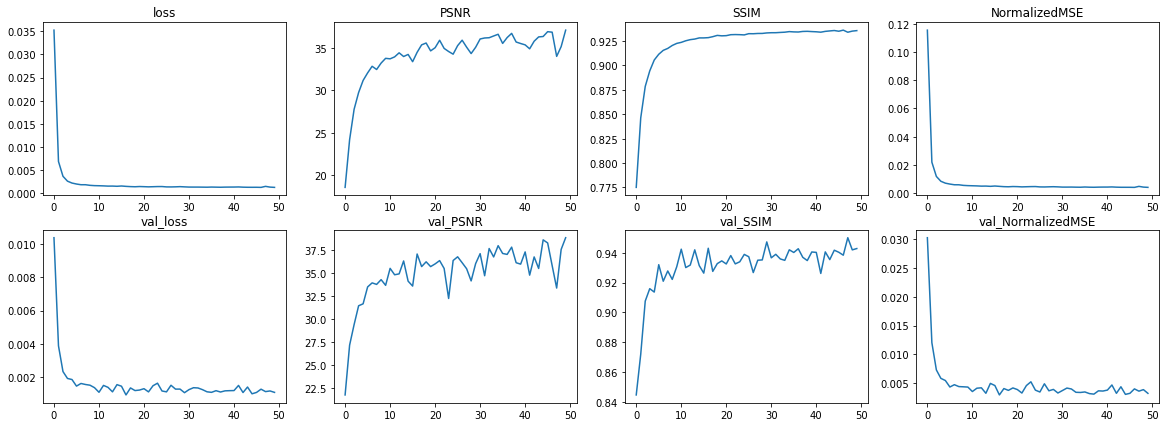

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=[20, 7])
keys = list(history.history.keys())
for i in range(len(keys)):
    key = keys[i]
    axes[i // 4, i % 4].set_title(key)
    axes[i // 4, i % 4].plot(history.history[key])

In [45]:
scale = 3

real_image = cv2.imread('./test_images/test6.jpg', 3)
cropped = real_image[0:(real_image.shape[0] - (real_image.shape[0] % scale)),
                    0:(real_image.shape[1] - (real_image.shape[1] % scale)), :]
lr = cv2.resize(cropped, (int(cropped.shape[1] / scale), int(cropped.shape[0] / scale)),
                        interpolation=cv2.INTER_AREA)
# lr = cropped
upscaled = cv2.resize(lr, (lr.shape[1] * scale, lr.shape[0] * scale), interpolation=cv2.INTER_CUBIC)
upscaled_area = cv2.resize(lr, (lr.shape[1] * scale, lr.shape[0] * scale), interpolation=cv2.INTER_AREA)

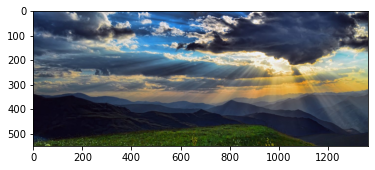

In [46]:
plt.imshow(cv2.cvtColor(real_image, cv2.COLOR_BGR2RGB))

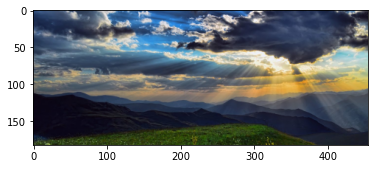

In [47]:
plt.imshow(cv2.cvtColor(lr, cv2.COLOR_BGR2RGB))

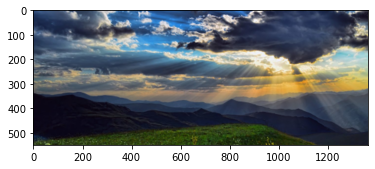

In [48]:
plt.imshow(cv2.cvtColor(upscaled, cv2.COLOR_BGR2RGB))

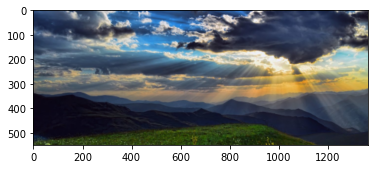

In [49]:
plt.imshow(cv2.cvtColor(upscaled_area, cv2.COLOR_BGR2RGB))

In [50]:
# predicted = SRCNN.predict(upscaled.reshape(1, *upscaled.shape) / 255.0)[0]
predicted = SRCNN.predict(upscaled.reshape(1, *upscaled.shape) / 255.0)[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


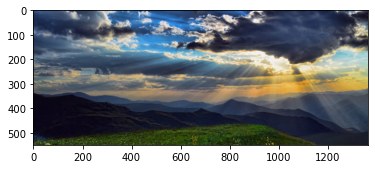

In [51]:
plt.imshow(cv2.cvtColor(predicted, cv2.COLOR_BGR2RGB))

In [52]:
cv2.imwrite('./test_images/SRCNN_test6_cubic.jpg', predicted * 255)
cv2.imwrite('./test_images/cubic_interpolated_test6.jpg', upscaled)
cv2.imwrite('./test_images/area_interpolated_test6.jpg', upscaled_area)
cv2.imwrite('./test_images/lr_test6.jpg', lr)

True

In [44]:
SRCNN.save('SRCNN_area_cubic')

INFO:tensorflow:Assets written to: SRCNN_area_cubic\assets
